# Imports

In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch
import scipy as sp
import itertools
rng = np.random.default_rng(seed=42)

## Extracting thermal conductivity from logfile


In [2]:
def extract_TC(file_path):
    """Extracts the thermal conductivity (TC) value from the logfile,
    assuming that the LAMMPS script has already been run.
    Also takes their thermal conductivities
    
    Inputs:
    file_path - path to the logfile we want to read
    
    Outputs:
    thermal_conductivity - thermal conductivity extracted from the logfile (if it is there)
    k_x - thermal conductivity along the x direction extracted from logfile
    k_y - thermal conductivity along the y direction extracted from logfile
    k_z - thermal conductivity along the z direction extracted from logfile
    """
    
    # Open file in Python to read all lines
    with open(file_path, 'r') as file:
        content = file.read()

    # Looks for lines of the form {average conductivity: X[W/mk] @ 70 K, Y /A\^3}
    k_pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    # Search logfile for that line
    k_lines = k_pattern.findall(content)
    
    # If the line exists, extract thermal conductivity. Inform user if otherwise
    if len(k_lines)>0:
        thermal_conductivity = float(k_lines[0])
    else:
        return 'Thermal conductivity not found for this file'
    
    # Look for lines of the form {diretional thermal conductivites: k_x = kx, k_y = ky, k_z = kz}
    ki_pattern = re.compile(
        r'Directional thermal conductivities:\s*'
        r'k_x\s*=\s*(?P<kx>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_y\s*=\s*(?P<ky>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)\s*,\s*'
        r'k_z\s*=\s*(?P<kz>[+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)',
        re.IGNORECASE)
    
    # If the line exists, extract directional conductivity. Inform user if otherwise
    ki_lines = ki_pattern.findall(content)
    if ki_lines:
        kx_str, ky_str, kz_str = ki_lines[0]
        kx = float(kx_str)
        ky = float(ky_str)
        kz = float(kz_str)
    else:
        return 'Directional thermal conductivites not found for this file'
    
    return thermal_conductivity, kx, ky, kz

## Updating the seed for the random velocities in LAMMPS


In [3]:
def update_seed(file_path, new_seed):
    """Updates the seed for the velocity initialisation command in the LAMMPS input script.
    The velocity in LAMMPS is randomly initialised using a given seed.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_seed - new seed to be used in velocity initialisation
    
    Outputs:
    Updated file, if amendments have been made"""
    
    # Looks for lines of the form {variable r equal X}
    pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # If the pattern exists, update the line with the new seed in place
            if pattern.match(line):
                line = f"variable r equal {new_seed}\n"
            
            # Write the line to the file
            file.write(line)

## Updating the masses of the atoms in LAMMPS input script


In [4]:
def update_masses(file_path, new_mass1, new_mass2):
    """Updates the mass1 and mass2 variables in the LAMMPS input script.
    This assumes of course that the LAMMPS script concerns two fundamental atoms.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    new_mass1 - new mass 1 (g/mol)
    new_mass2 - new mass 2 (g/mol)
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Looks for lines of the form {mass    1 X} and {mass    2 Y}
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        for line in lines:
            # --- Mass 1 ---
            # If the pattern exists, replace mass 1 with new_mass1
            if target_pattern_mass1.match(line):
                line = f"mass 1 {new_mass1}\n"
            # --- Mass 2 ---
            if target_pattern_mass2.match(line):
                line = f"mass 2 {new_mass2}\n"
                
            file.write(line)

## Updating dimensonality of LAMMPS input script

In [5]:
def update_dimensionality(file_path, new_dimension):
    """Updates the dimensionality written in the LAMMPS input script.
    
    Inputs:
    file_path - path to the LAMMPS script which will be updated
    
    Outputs:
    Updated file, if any amendments have been made"""
    
    # Look for lines of the form {dimension X}
    pattern = re.compile(r'^\s*dimension\s+(\d+)\b(?=\s*(?:#|$))')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines iteratively
    with open(file_path, 'w') as file:
        # Update any line which matches line pattern
        for line in lines:
            if pattern.match(line):
                line = f"dimension {new_dimension}\n"
            
            file.write(line)

## Bash function

In [6]:
def run_bash():
    """ I want to describe this better """
    !bash {'lammps.sh'}
    return

## Creating a LAMMPS-compatible datafile

In [7]:
def layered_datafile_creation(Ncells, layer_types, spacings):
    """Creates a datafile of an arbitrary crystallographic material which is LAMMPS compatible.
    Uses the generate_FCC function to generate FCC lattice.
    See the markdown above where this function is defined for details on the datafile structure.
    Alternativiely, view the eim example in LAMMPS.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    layer_types - one-dimensional NumPy array indicating the typing of layers
    spacings - lattice constant / spacing between cells
    
    Output:
    datafile.txt - datafile in LAMMPS format defining the structure"""

    # Find positions, types, IDs and group into data
    positions, atom_types, layer_types = generate_FCC(Ncells, layer_types, spacings)
    num_atoms = len(atom_types)
    IDs = np.array(range(1, num_atoms+1))
    data = np.column_stack((IDs, atom_types, positions))

    # Will take the form [ID] [Type] [X1] [Y1] [Z1] column-repeated many times
    np.savetxt('datafile.txt', data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

2 atom types

{min(positions[:,0])} {max(positions[:,0]) + 0.5*spacings[0]} xlo xhi
{min(positions[:,1])} {max(positions[:,1]) + 0.5*spacings[1]} ylo yhi
{min(positions[:,2])} {max(positions[:,2]) + 0.5*spacings[2]} zlo zhi

Atoms
''', comments = '')
    
    return

Below we have to be careful since a naive sublayering of the Fibonacci sequence (L, H, LL, HHH...) can result in an odd number of sub-layers, therefore we do not have an integer amount of unit cells and this could cause some troubles if we are not careful. So I decide instead to do something of the form (LL, HH, LLLL, HHHHHH) i.e. Fibonacci over the cells rather than the sublayers along y.

In [8]:
def generate_FCC(Ncells, layer_types, spacings):
    """Creates a face-centered cubic (FCC) structure.
    This specific function assumes two types of atom only.
    
    Inputs:
    Ncells - number of cells as a two-dimensional NumPy vector [Nx, Nz]
    layer_types - one-dimensional NumPy array indicating the typing of layers
    spacings - lattice constant / spacing between cells
    
    Outputs:
    positions - two-dimensional NumPy array of positions [x,y,z] per atom
    type_atoms - one-dimensional NumPy array labelling atom types as integers
    layer_types - one-dimensional NumPy array labelling layer types as integers"""
    # Create storage arrays
    positions_even, positions_odd = [], []
    types_even, types_odd = [], []

    # Extract spacing and cells
    x_spacing, y_spacing, z_spacing = spacings
    Ncells_x, Ncells_z = Ncells

    # Determine Cartesian range of atoms
    x_range, z_range = range(2*Ncells_x), range(2*Ncells_z) 
    Nlayers = len(layer_types)
    y_range = range(0, 2*Nlayers)
    
    # Loop over the range of x,y,z
    for x,y,z in itertools.product(x_range, y_range, z_range):
        
        # Because we do Fibonacci over the cells, layer_types is defined differently
        # essentially a thickness=2, the first two y correspond to the first type defined in layer_types
        atom_type = layer_types[y//2]
        
        # Check the first layer:
        if y%2 == 0:
            # Check if x+z is even
            if (x+z)%2 == 0:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2)*y_spacing
                # Append positions and types
                positions_even.append([x,y,z])
                types_even.append(atom_type)
                
        # Check the second layer:
        elif y%2 == 1:
            # Check if x+z is odd
            if (x+z)%2 == 1:
                x, z = x*0.5*x_spacing, z*0.5*z_spacing
                y = (y//2 + 0.5)*y_spacing
                # Append positions and types
                positions_odd.append([x,y,z])
                types_odd.append(atom_type)
                                    
    # Convert lists to arrays for plotting & return
    positions_even = np.array(positions_even)
    positions_odd = np.array(positions_odd)
    positions = np.concatenate( (positions_even, positions_odd), axis=0 )
    types_even = np.array(types_even)
    types_odd = np.array(types_odd)
    atom_types = np.concatenate( (types_even, types_odd), axis=0 )
    
    return positions, atom_types, layer_types

# Investigating Fibonacci sequences

In [9]:
k_averages = []; kx_averages = []; ky_averages = []; kz_averages = []
k_errors = []; kx_errors = []; ky_errors = []; kz_errors = []

## Fibonacci [L, H, LL, HHH]

In [10]:
spacings = np.array([5.376,5.376,5.376])
mass1 = 39.948; mass2 = 100.0
update_masses("tc.txt", mass1, mass2)

layer_types = np.array([1, 2, 1,1, 2,2,2])
type1 = np.sum(layer_types==1)
type2 = np.sum(layer_types==2)

avg_mass = (mass1*type1 + mass2*type2) / (type1+type2)

# Create datafile for LAMMPS to use
Ncells = np.array([5,5])
layered_datafile_creation(Ncells, layer_types, spacings)
# Update seeds
seeds = np.random.randint(1,100000,7)
# Thermal conductivites per layer
k_run, kx_run, ky_run, kz_run = [], [], [], []
# Loop over seeds
for seed in tqdm(seeds):
    update_seed("tc.txt", seed)
    run_bash()
    # Extract TC and directional TC
    k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
    # Store all seed TC's
    k_run.append(k_seed)
    kx_run.append(kx_seed)
    ky_run.append(ky_seed)
    kz_run.append(kz_seed)
# Find all TC averages per layer
k_average = (np.mean(k_run))
kx_average = (np.mean(kx_run))
ky_average = (np.mean(ky_run))
kz_average = (np.mean(kz_run))
# Also find their errors
k_error = (np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
kx_error = (np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
ky_error = (np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
kz_error = (np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:26<00:00, 55.17s/it]


In [11]:
print(f"Thermal conductivity k={k_average} W/m^3 with error {k_error} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_average} W/m^3 with error {kx_error} W/m^3 \n ky = {ky_average} W/m^3 with error {ky_error} W/m^3 \n kz = {kz_average} W/m^3 with error {kz_error} W/m^3")

Thermal conductivity k=0.169941439765754 W/m^3 with error 0.011545122758299253 W/m^3
Directional thermal conductivities: 
 kx = 0.16434197405532128 W/m^3 with error 0.011868531396743282 W/m^3 
 ky = 0.13622731838499727 W/m^3 with error 0.012612194268271011 W/m^3 
 kz = 0.20925502685694314 W/m^3 with error 0.017908386843572776 W/m^3


In [12]:
k_averages.append(k_average/avg_mass)
kx_averages.append(kx_average/avg_mass)
ky_averages.append(ky_average/avg_mass)
kz_averages.append(kz_average/avg_mass)

k_errors.append(k_error/avg_mass)
kx_errors.append(kx_error/avg_mass)
ky_errors.append(ky_error/avg_mass)
kz_errors.append(kz_error/avg_mass)

## Fibonacci [L, H, LL, HHH, LLLLL]

In [13]:
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

layer_types = np.array([1, 2, 1,1, 2,2,2, 1,1,1,1,1])
type1 = np.sum(layer_types==1)
type2 = np.sum(layer_types==2)

avg_mass = (mass1*type1 + mass2*type2) / (type1+type2)

# Create datafile for LAMMPS to use
Ncells = np.array([5,5])
layered_datafile_creation(Ncells, layer_types, spacings)
# Update seeds
seeds = np.random.randint(1,100000,7)
# Thermal conductivites per layer
k_run, kx_run, ky_run, kz_run = [], [], [], []
# Loop over seeds
for seed in tqdm(seeds):
    update_seed("tc.txt", seed)
    run_bash()
    # Extract TC and directional TC
    k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
    # Store all seed TC's
    k_run.append(k_seed)
    kx_run.append(kx_seed)
    ky_run.append(ky_seed)
    kz_run.append(kz_seed)
# Find all TC averages per layer
k_average = (np.mean(k_run))
kx_average = (np.mean(kx_run))
ky_average = (np.mean(ky_run))
kz_average = (np.mean(kz_run))
# Also find their errors
k_error = (np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
kx_error = (np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
ky_error = (np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
kz_error = (np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:56<00:00, 85.17s/it]


In [14]:
print(f"Thermal conductivity k={k_average} W/m^3 with error {k_error} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_average} W/m^3 with error {kx_error} W/m^3 \n ky = {ky_average} W/m^3 with error {ky_error} W/m^3 \n kz = {kz_average} W/m^3 with error {kz_error} W/m^3")

Thermal conductivity k=0.19614072190693774 W/m^3 with error 0.00728310319441491 W/m^3
Directional thermal conductivities: 
 kx = 0.18608159771758312 W/m^3 with error 0.012236126773924922 W/m^3 
 ky = 0.192493015776801 W/m^3 with error 0.013012807801677219 W/m^3 
 kz = 0.20984755222642917 W/m^3 with error 0.022799022801923054 W/m^3


In [15]:
k_averages.append(k_average/avg_mass)
kx_averages.append(kx_average/avg_mass)
ky_averages.append(ky_average/avg_mass)
kz_averages.append(kz_average/avg_mass)

k_errors.append(k_error/avg_mass)
kx_errors.append(kx_error/avg_mass)
ky_errors.append(ky_error/avg_mass)
kz_errors.append(kz_error/avg_mass)

## Fibonacci [L, H, LL, HHH, LLLLL, HHHHHHHH]

In [16]:
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

layer_types = np.array([1, 2, 1,1, 2,2,2, 1,1,1,1,1, 2,2,2,2,2,2,2,2])
type1 = np.sum(layer_types==1)
type2 = np.sum(layer_types==2)

avg_mass = (mass1*type1 + mass2*type2) / (type1+type2)

# Create datafile for LAMMPS to use
Ncells = np.array([5,5])
layered_datafile_creation(Ncells, layer_types, spacings)
# Update seeds
seeds = np.random.randint(1,100000,7)
# Thermal conductivites per layer
k_run, kx_run, ky_run, kz_run = [], [], [], []
# Loop over seeds
for seed in tqdm(seeds):
    update_seed("tc.txt", seed)
    run_bash()
    # Extract TC and directional TC
    k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
    # Store all seed TC's
    k_run.append(k_seed)
    kx_run.append(kx_seed)
    ky_run.append(ky_seed)
    kz_run.append(kz_seed)
# Find all TC averages per layer
k_average = (np.mean(k_run))
kx_average = (np.mean(kx_run))
ky_average = (np.mean(ky_run))
kz_average = (np.mean(kz_run))
# Also find their errors
k_error = (np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
kx_error = (np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
ky_error = (np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
kz_error = (np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [14:39<00:00, 125.60s/it]


In [17]:
print(f"Thermal conductivity k={k_average} W/m^3 with error {k_error} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_average} W/m^3 with error {kx_error} W/m^3 \n ky = {ky_average} W/m^3 with error {ky_error} W/m^3 \n kz = {kz_average} W/m^3 with error {kz_error} W/m^3")

Thermal conductivity k=0.19346334647580327 W/m^3 with error 0.008114911182381127 W/m^3
Directional thermal conductivities: 
 kx = 0.2347401355757803 W/m^3 with error 0.020975995313541756 W/m^3 
 ky = 0.13074725017462235 W/m^3 with error 0.008643815593019306 W/m^3 
 kz = 0.21490265367700728 W/m^3 with error 0.015259552656039418 W/m^3


In [18]:
k_averages.append(k_average/avg_mass)
kx_averages.append(kx_average/avg_mass)
ky_averages.append(ky_average/avg_mass)
kz_averages.append(kz_average/avg_mass)

k_errors.append(k_error/avg_mass)
kx_errors.append(kx_error/avg_mass)
ky_errors.append(ky_error/avg_mass)
kz_errors.append(kz_error/avg_mass)

## Fibonacci [L, H, LL, HHH, LLLLL, HHHHHHHH, L*13]

In [23]:
spacings = np.array([5.376,5.376,5.376])
update_masses("tc.txt", 39.948, 100.0)

layer_types = np.array([1, 2, 1,1, 2,2,2, 1,1,1,1,1, 2,2,2,2,2,2,2,2, 1,1,1,1,1,1,1,1,1,1,1,1,1])
type1 = np.sum(layer_types==1)
type2 = np.sum(layer_types==2)

avg_mass = (mass1*type1 + mass2*type2) / (type1+type2)

# Create datafile for LAMMPS to use
Ncells = np.array([5,5])
layered_datafile_creation(Ncells, layer_types, spacings)
# Update seeds
seeds = np.random.randint(1,100000,7)
# Thermal conductivites per layer
k_run, kx_run, ky_run, kz_run = [], [], [], []
# Loop over seeds
for seed in tqdm(seeds):
    update_seed("tc.txt", seed)
    run_bash()
    # Extract TC and directional TC
    k_seed, kx_seed, ky_seed, kz_seed = extract_TC("log.lammps")
    # Store all seed TC's
    k_run.append(k_seed)
    kx_run.append(kx_seed)
    ky_run.append(ky_seed)
    kz_run.append(kz_seed)
# Find all TC averages per layer
k_average = (np.mean(k_run))
kx_average = (np.mean(kx_run))
ky_average = (np.mean(ky_run))
kz_average = (np.mean(kz_run))
# Also find their errors
k_error = (np.std(k_run, ddof=1) / np.sqrt(len(k_run)))
kx_error = (np.std(kx_run, ddof=1) / np.sqrt(len(kx_run)))
ky_error = (np.std(ky_run, ddof=1) / np.sqrt(len(ky_run)))
kz_error = (np.std(kz_run, ddof=1) / np.sqrt(len(kz_run)))

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [23:20<00:00, 200.13s/it]


In [24]:
print(f"Thermal conductivity k={k_average} W/m^3 with error {k_error} W/m^3")
print(f"Directional thermal conductivities: \n kx = {kx_average} W/m^3 with error {kx_error} W/m^3 \n ky = {ky_average} W/m^3 with error {ky_error} W/m^3 \n kz = {kz_average} W/m^3 with error {kz_error} W/m^3")

Thermal conductivity k=0.25919971920922613 W/m^3 with error 0.013115647438819126 W/m^3
Directional thermal conductivities: 
 kx = 0.25064379043210927 W/m^3 with error 0.013540705531650786 W/m^3 
 ky = 0.25186601297197286 W/m^3 with error 0.012045613007692546 W/m^3 
 kz = 0.2750893542235963 W/m^3 with error 0.022214566320459313 W/m^3


In [25]:
k_averages.append(k_average/avg_mass)
kx_averages.append(kx_average/avg_mass)
ky_averages.append(ky_average/avg_mass)
kz_averages.append(kz_average/avg_mass)

k_errors.append(k_error/avg_mass)
kx_errors.append(kx_error/avg_mass)
ky_errors.append(ky_error/avg_mass)
kz_errors.append(kz_error/avg_mass)

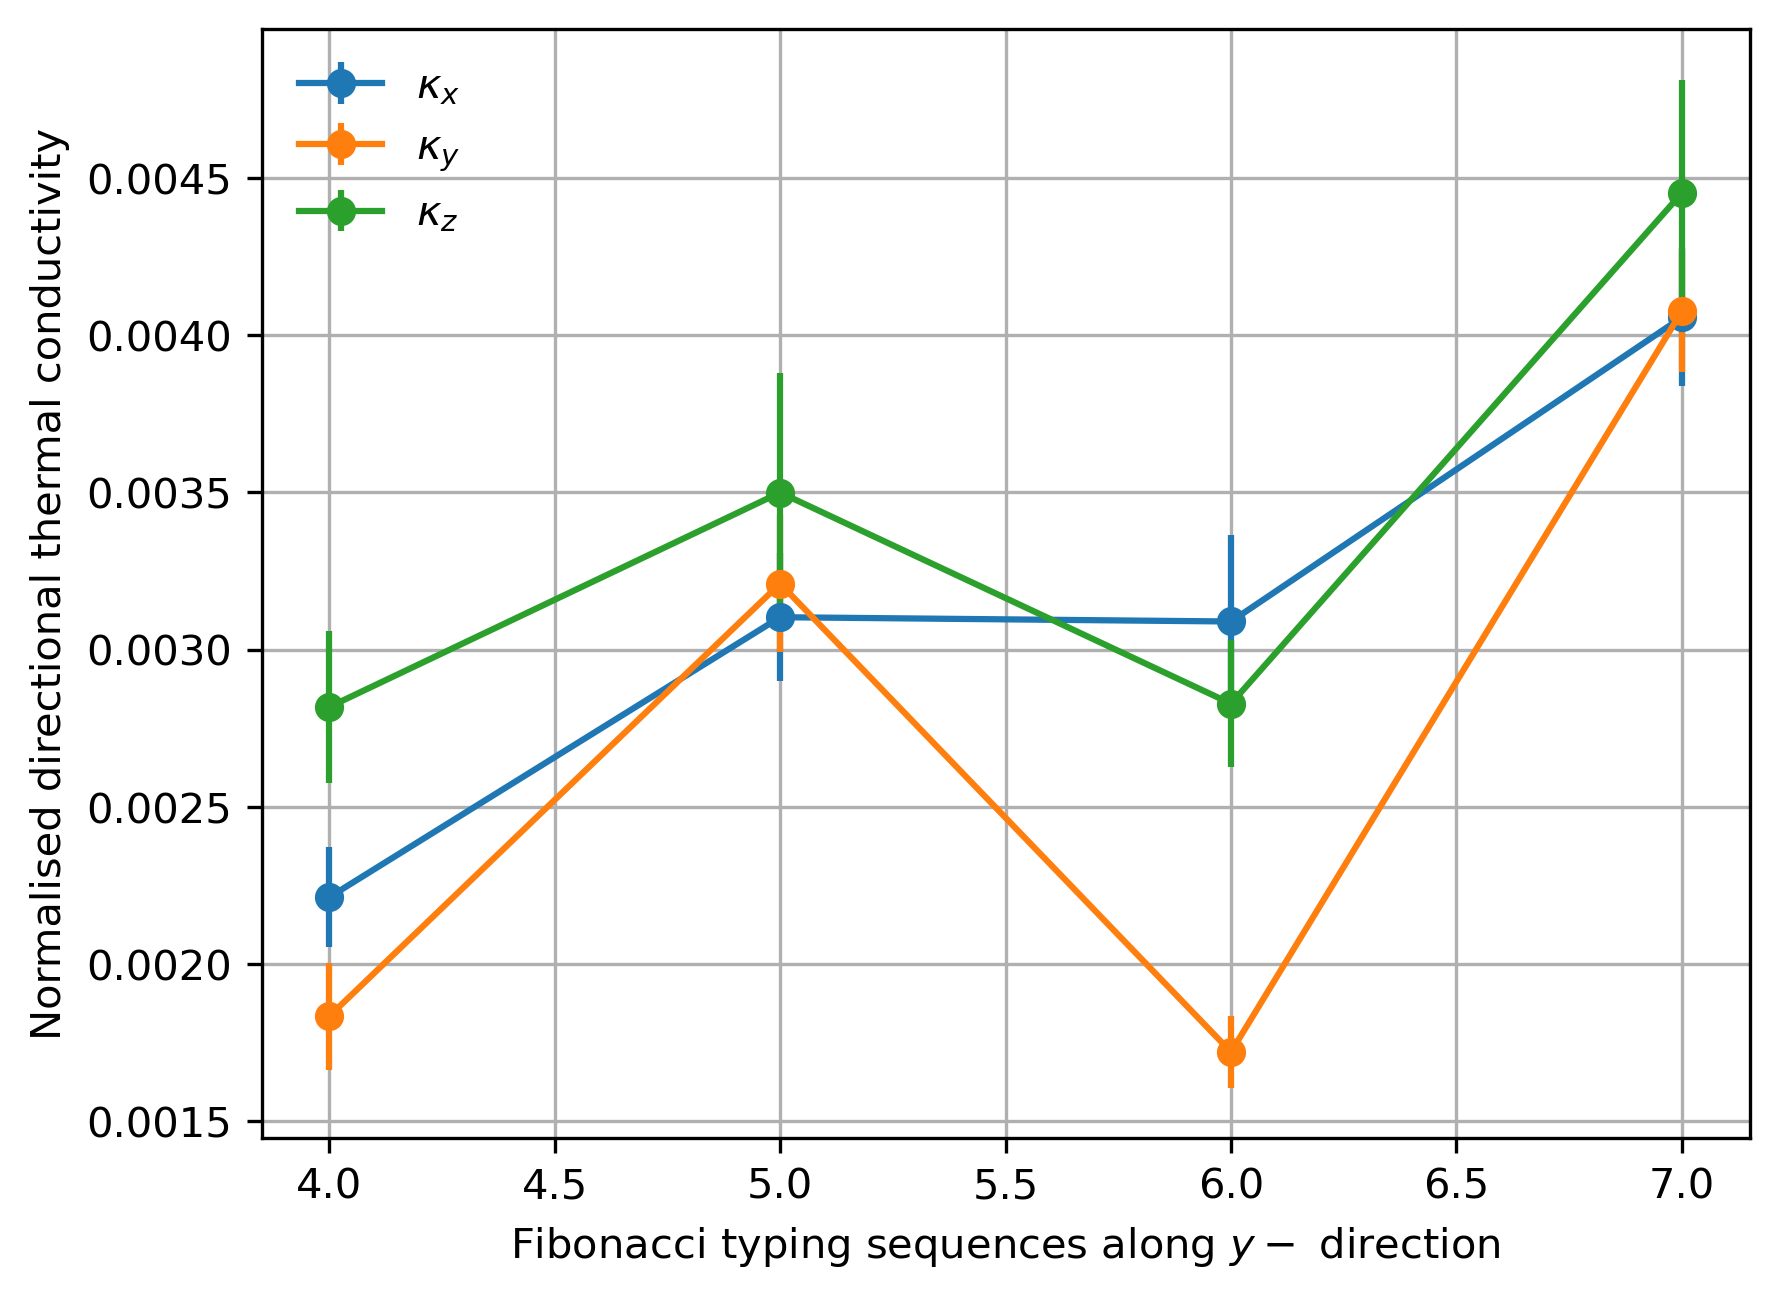

In [27]:
sequences = np.array([4,5,6,7])
plt.errorbar(sequences, kx_averages, yerr=kx_errors, fmt='o-', label="$\kappa_x$")
plt.errorbar(sequences, ky_averages, yerr=ky_errors, fmt='o-', label="$\kappa_y$")
plt.errorbar(sequences, kz_averages, yerr=kz_errors, fmt='o-', label="$\kappa_z$")
plt.grid()
plt.xlabel("Fibonacci typing sequences along $y-$ direction")
plt.ylabel("Normalised directional thermal conductivity")
plt.legend()

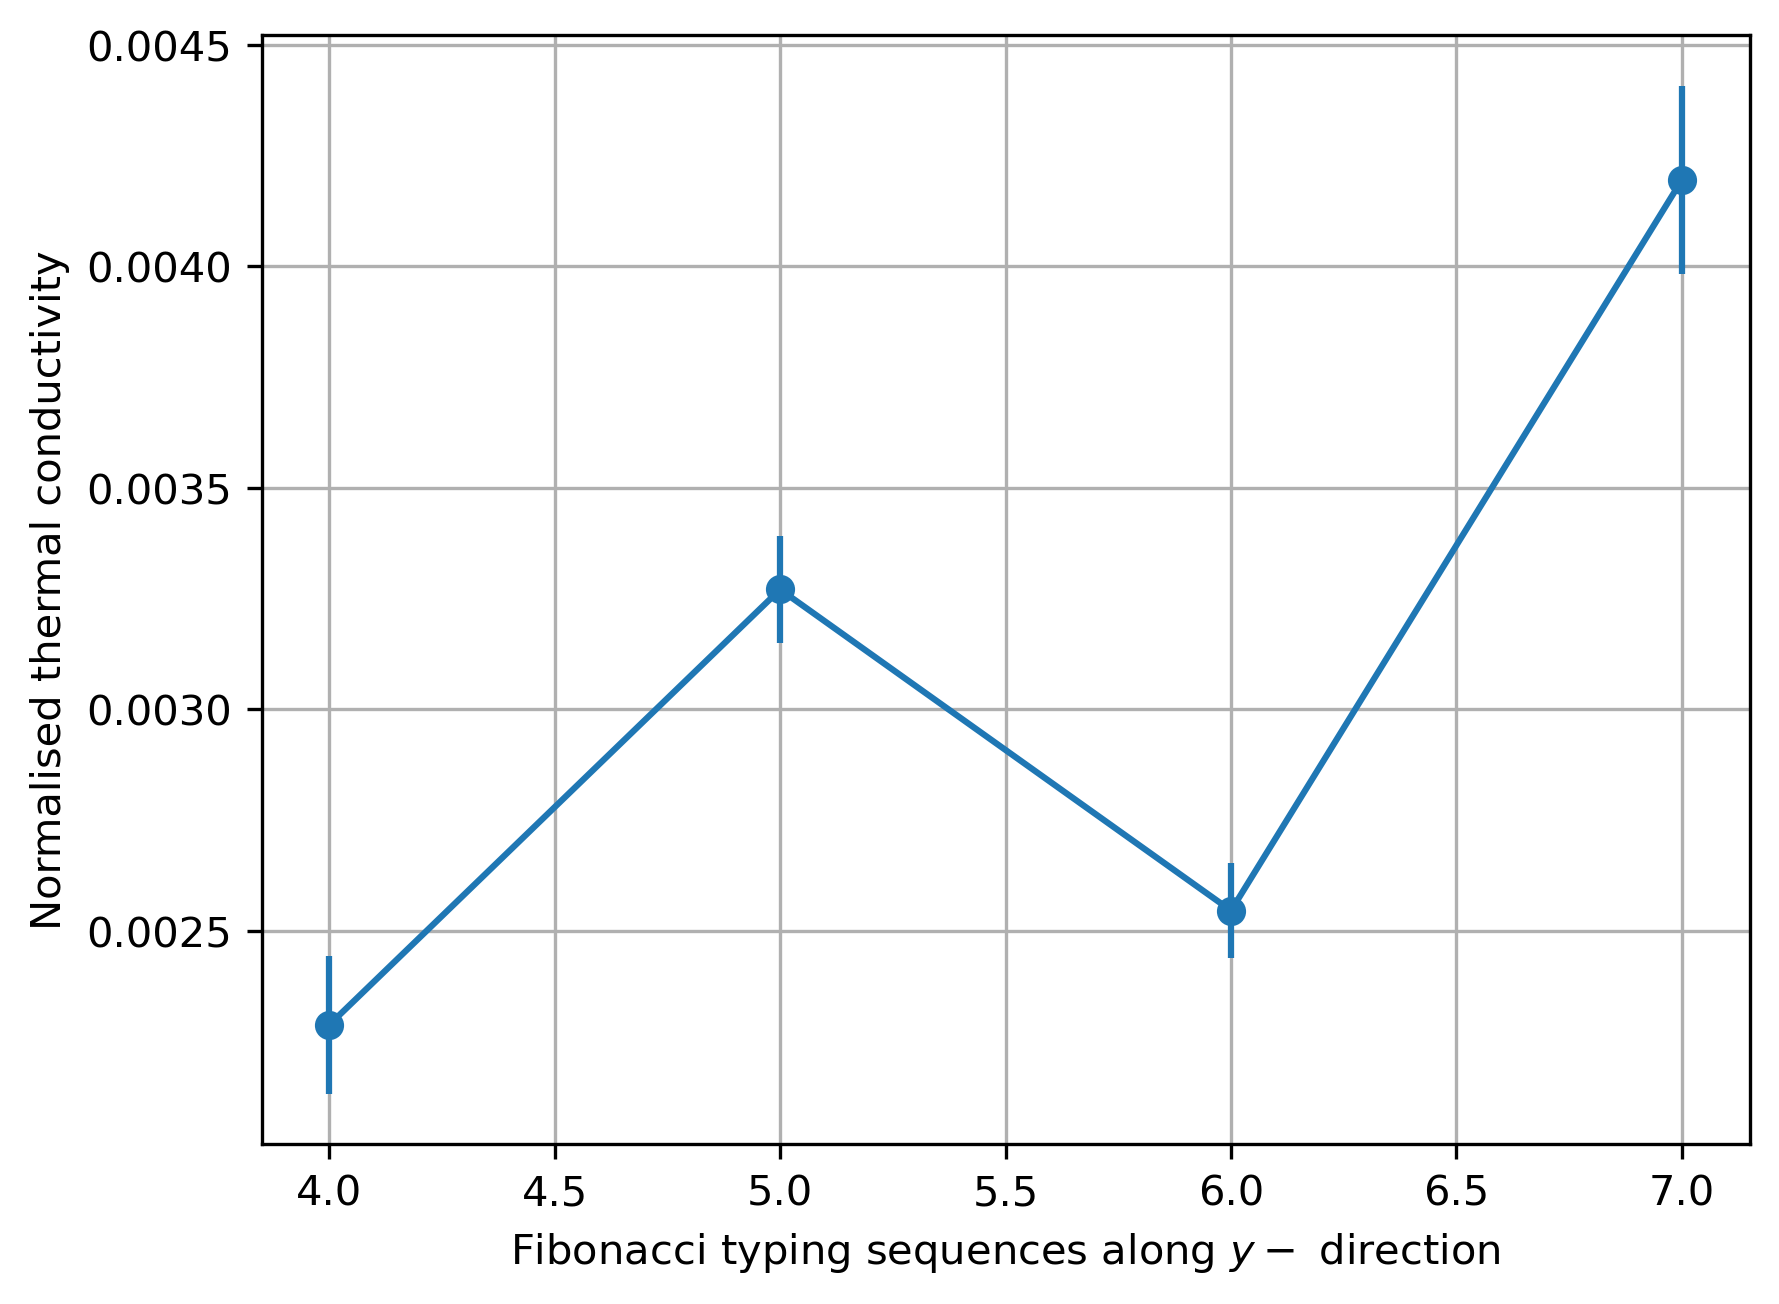

In [28]:
plt.errorbar(sequences, k_averages, yerr=k_errors, fmt='o-')
plt.grid()
plt.xlabel("Fibonacci typing sequences along $y-$ direction")
plt.ylabel("Normalised thermal conductivity")
plt.show()